In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

In [66]:
cols = ["# y_exit", "z_exit", "x_start", "y_start", "z_start", "px_start", "py_start", "pz_start"]
df = pd.concat([pd.read_csv(f"data/simulation/job_{i}.txt", sep="\t", header=0, usecols=cols) for i in range(24)], ignore_index=True)

df.to_hdf("data/simdata.h5",key="simulation")

In [3]:
df = pd.read_hdf("data/simdata.h5")
point=np.arange(1,25)
fiber=np.arange(1,51)

print(point,fiber)
df

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


,# y_exit,z_exit,x_start,y_start,z_start,px_start,py_start,pz_start
0,-0.026978,-0.061619,2400.019897,-0.051878,0.096635,0.948434,0.162628,-0.272077
1,-0.055254,0.050902,2400.000732,0.085666,0.015889,0.977825,-0.139056,-0.156593
2,0.049212,0.065583,2399.990967,0.006511,-0.025208,0.917937,-0.225034,0.326729
3,-0.018177,-0.106197,2400.062012,-0.043234,-0.098842,0.885576,0.074564,-0.458470
4,0.050591,0.043467,2400.000977,-0.004035,-0.069628,0.971248,-0.103995,-0.214154
...,...,...,...,...,...,...,...,...
11807967,0.053738,-0.075124,100.000000,0.061661,0.023451,0.926533,-0.225631,-0.301045
11807968,0.072895,0.068957,99.993042,0.055767,0.052309,0.803233,-0.442604,0.398647
11807969,-0.060896,0.015096,99.994385,-0.075861,0.078159,0.908749,0.389061,-0.151020
11807970,-0.097467,0.013077,83.746460,0.030384,0.090095,0.927012,0.372600,-0.042642


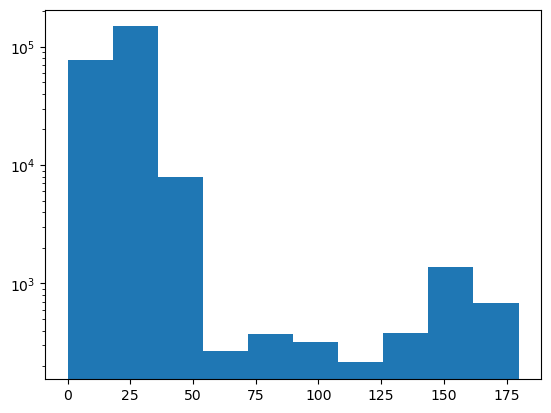

In [95]:
px = df["px_start"].to_numpy()
py = df["py_start"].to_numpy()
pz = df["pz_start"].to_numpy()

x = df["x_start"].to_numpy()
y = df["y_start"].to_numpy()
z = df["z_start"].to_numpy()

p = px**2+py**2+pz**2
theta=np.rad2deg(np.arccos(px))

plt.hist(theta)
plt.yscale("log")

In [96]:
def r_min(x0,p0): # c0 + c*y, x0 + p0*x
    c = np.stack(np.array([1,0,0]))
    n = np.cross(p0,c)
    E = np.dot(n,-x0)
    NF = E/np.linalg.norm(n)
    r_min = np.abs(NF)
    
    return r_min

p0 = np.stack((px,py,pz), axis=-1)
x0 = np.stack((x,y,z), axis=-1)
rmin = np.empty(len(p0))
for i in range(len(p0)):
    rmin[i] = r_min(x0[i],p0[i])
print(rmin)

[0.00504941 0.05350554 0.0089363  ... 0.09730021 0.08699475 0.07477021]


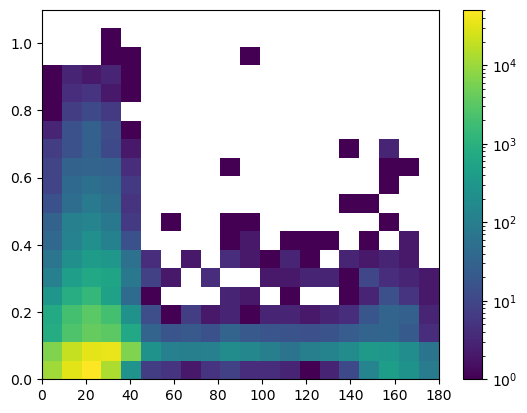

In [97]:
bins_theta = np.linspace(0,180,21)
bins_rmin = np.linspace(0,1.1,21)
A, bt, br = np.histogram2d(theta, rmin, bins=[bins_theta, bins_rmin])
plt.hist2d(theta,rmin,bins=[bt,br],cmap="viridis",norm=LogNorm())
plt.colorbar()

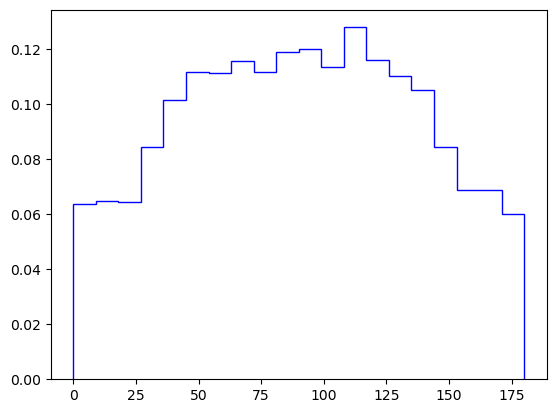

In [102]:
stat,edge,no  = binned_statistic(theta,rmin,bins=bins_theta)
stat
plt.stairs(stat, edge, color="b")
mid = edge[:-1] + np.diff(edge)/2

In [105]:
gauss = lambda x,a,mu,sigma,c: a/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/sigma**2) + c

gauss_par, gauss_cov = curve_fit(gauss,mid,stat,p0=[1,100,50,0.06],sigma=None,absolute_sigma=False)

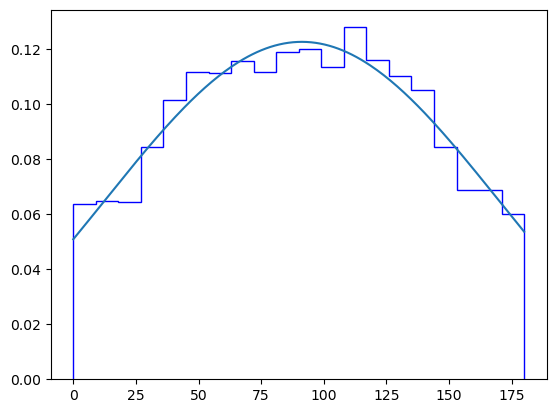

In [106]:
linplt = np.linspace(0,180,200)
plt.stairs(stat, edge, color="b")
plt.plot(linplt,gauss(linplt,*gauss_par))

(array([ 2322.,  7039., 11913., 16643., 21985., 27010., 32492., 38523.,
        36933., 20863., 13832.,  4410.,  1130.,   349.,   153.,   161.,
          156.,   233.,   614.,     0.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36.,
        39., 42., 45., 48., 51., 54., 57., 60.]),
 <BarContainer object of 20 artists>)

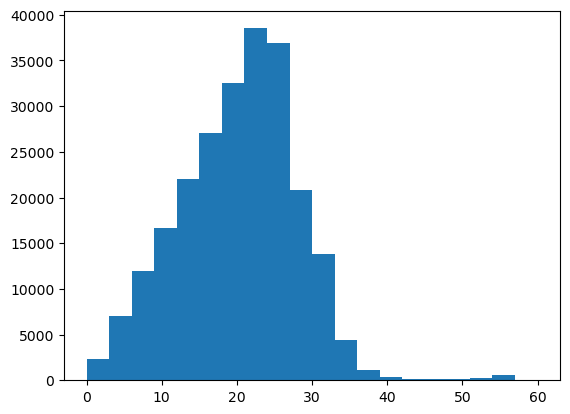

In [118]:
r_core = 0.22
theta_refl = np.rad2deg(np.arcsin(np.sqrt(1-(gauss(theta,*gauss_par)**2 / r_core**2))*np.sin(np.deg2rad(theta))))
bins_theta_refl = np.linspace(0,60,21)
plt.hist(theta_refl,bins=bins_theta_refl)

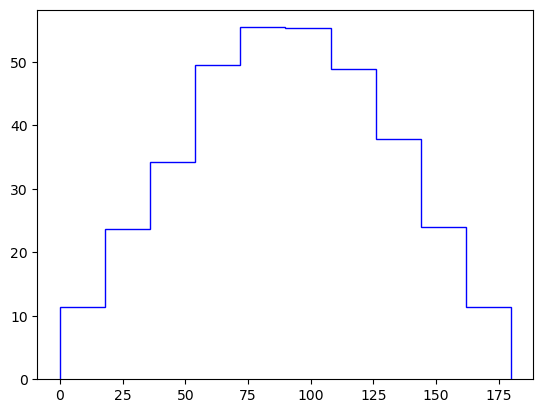

In [121]:
stat_refl, edge_refl, no_refl = binned_statistic(theta,theta_refl)
plt.stairs(stat_refl, edge_refl, color="b")

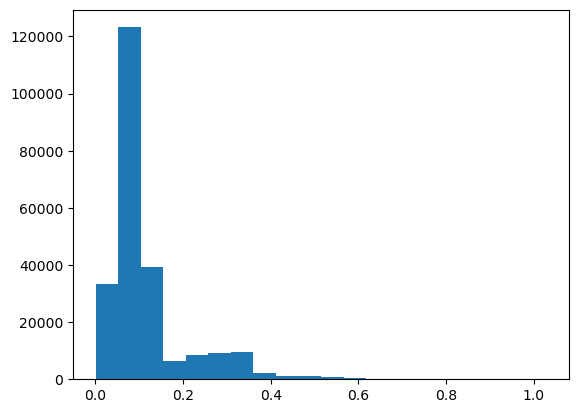

In [130]:
y_ex = df["# y_exit"].to_numpy()
z_ex = df["z_exit"].to_numpy()

r_ex = np.sqrt(y_ex**2 + z_ex**2)
plt.hist(r_ex, bins=20)

mask_clad = np.logical_and(r_ex<=0.25,r_ex>0.22)
mask_core = r_ex<=0.22

r_ex_cladding = r_ex[mask_clad]
theta_cladding = theta[mask_clad]
r_ex_core = r_ex[mask_core]
theta_core = theta[mask_core]

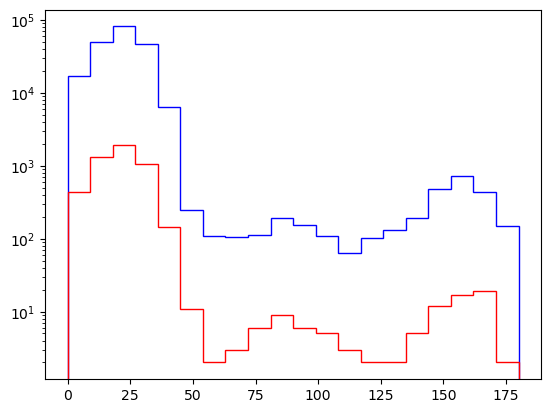

In [146]:
stat_core, edge_core, no_core = binned_statistic(theta_core,r_ex_core,bins=bins_theta,statistic="count")
stat_clad, edge_clad, no_clad = binned_statistic(theta_cladding,r_ex_cladding,bins=bins_theta,statistic="count")

plt.stairs(stat_core, edge_core, color="b")
plt.stairs(stat_clad, edge_clad, color="r")
plt.yscale("log")